In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import math
import matplotlib
#matplotlib.use("Agg")
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import glob
from data_utils import load_data, augment_data,normalise_train,normalise_test,rgb2gray,rgb2lab,lab2rgb
import matplotlib.pyplot as plt
from tucha import complex_pokemon_model,baselinish,simpler_model,baselinish2,complex_pokemon_model2,baselinish3

from cs231n.data_utils import load_CIFAR10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1,3])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,3]))
    return

In [5]:
def show_images2(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]),cmap = plt.get_cmap('gray'))
    return

Training data shape:  (50000, 32, 32, 3)
Test data shape:  (10000, 32, 32, 3)


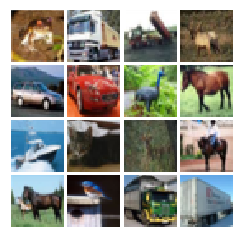

In [6]:
from skimage import img_as_float
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Test data shape: ', X_test.shape)
X_train = img_as_float(X_train.astype('uint8'))
#X_test = img_as_float(X_test.astype('uint8'))
X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
show_images(X_train[:16])
#show_images(X_test[:16])

In [23]:
def my_model(x,drop_o,is_training):
    
    W_conv = tf.get_variable("Wconv",shape = [7,7,3,32])
    b_conv = tf.get_variable("bconv",shape = [32])
    a1 = tf.nn.conv2d(x, W_conv, strides=[1,1,1,1], padding='SAME') + b_conv
    a1 = tf.contrib.layers.batch_norm(a1,center = True, scale = True, is_training = is_training,scope = 'bn1')
    a1 = tf.nn.relu(a1)
    a1 = tf.nn.max_pool(a1,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'VALID')
    
    W_conv2 = tf.get_variable("Wconv2",shape = [5,5,32,64])
    b_conv2 = tf.get_variable("bconv2",shape = [64])
    a1 = tf.nn.conv2d(a1, W_conv2, strides=[1,1,1,1], padding='SAME') + b_conv2
    a1 = tf.contrib.layers.batch_norm(a1,center = True, scale = True, is_training = is_training,scope = 'bn2')
    a1 = tf.nn.relu(a1)
    
    a1 = tf.nn.max_pool(a1,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'VALID')
    a1 = tf.nn.dropout(a1,drop_o)
   
    W_conv3 = tf.get_variable("Wconv3",shape = [3,3,64,96])
    b_conv3 = tf.get_variable("bconv3",shape = [96])
    a1 = tf.nn.conv2d(a1, W_conv3, strides=[1,1,1,1], padding='SAME') + b_conv3
    a1 = tf.contrib.layers.batch_norm(a1,center = True, scale = True, is_training = is_training,scope = 'bn3')
    a1 = tf.nn.relu(a1)
    a1 = tf.nn.dropout(a1,drop_o)
    #a1 = tf.nn.max_pool(a1,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'VALID')
    
    a1_flat = tf.reshape(a1,[-1,8*8*96])
    W1 = tf.get_variable("W1",shape = [8*8*96,1024])
    b1 = tf.get_variable("b1",shape = [1024])
    W2 = tf.get_variable("W2",shape = [1024,1024])
    b2 = tf.get_variable("b2",shape = [1024])
    W3 = tf.get_variable("W3",shape = [1024,10])
    b3 = tf.get_variable("b3",shape = [10])
    
    affine = tf.matmul(a1_flat,W1) + b1
    affine = tf.nn.relu(affine)
    affine = tf.nn.dropout(affine,drop_o)
    
    affine = tf.matmul(affine,W2) + b2
    affine = tf.nn.relu(affine)
    affine = tf.nn.dropout(affine,drop_o)
    
    y_out = tf.matmul(affine,W2) + b2
    return y_out
  

In [24]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
dropout = tf.placeholder(tf.float32, shape = ())

with tf.variable_scope("model") as scope:
    y_out = my_model(X,dropout,is_training)

mean_loss = None
optimizer = None

total_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = y_out,labels = y)
mean_loss = tf.reduce_mean(total_loss)

optimizer = tf.train.AdamOptimizer(1e-4)
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [25]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False,drop_o = 1):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            if(training_now):
                feed_dict = {X: Xd[idx,:],
                             y: yd[idx],
                             is_training: training_now,
                             dropout:drop_o}
            else :
                feed_dict = {X: Xd[idx,:],
                             y: yd[idx],
                             is_training: training_now,
                             dropout:1
                             }
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct
    

Training
EPOCH = %d 0
Iteration 0: with minibatch training loss = 7.31 and accuracy of 0
Iteration 100: with minibatch training loss = 2.48 and accuracy of 0.2
Iteration 200: with minibatch training loss = 2.24 and accuracy of 0.27
Iteration 300: with minibatch training loss = 1.75 and accuracy of 0.34
Iteration 400: with minibatch training loss = 1.93 and accuracy of 0.27
Iteration 500: with minibatch training loss = 1.75 and accuracy of 0.42
Iteration 600: with minibatch training loss = 1.72 and accuracy of 0.33
Iteration 700: with minibatch training loss = 1.5 and accuracy of 0.44
Epoch 1, Overall loss = 2.02 and accuracy of 0.313


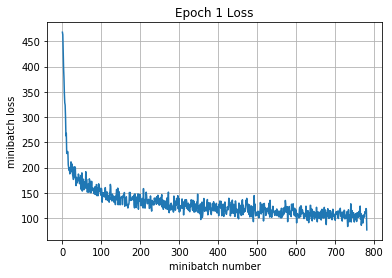

Validation
Epoch 1, Overall loss = 3.23 and accuracy of 0.102
EPOCH = %d 1
Iteration 0: with minibatch training loss = 1.53 and accuracy of 0.45
Iteration 100: with minibatch training loss = 1.67 and accuracy of 0.45
Iteration 200: with minibatch training loss = 1.48 and accuracy of 0.45
Iteration 300: with minibatch training loss = 1.57 and accuracy of 0.48
Iteration 400: with minibatch training loss = 1.63 and accuracy of 0.34
Iteration 500: with minibatch training loss = 1.59 and accuracy of 0.34
Iteration 600: with minibatch training loss = 1.33 and accuracy of 0.58
Iteration 700: with minibatch training loss = 1.09 and accuracy of 0.58
Epoch 1, Overall loss = 1.51 and accuracy of 0.452


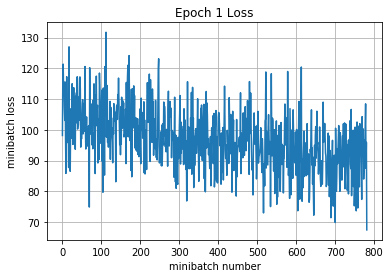

Validation
Epoch 1, Overall loss = 3.58 and accuracy of 0.128
EPOCH = %d 2
Iteration 0: with minibatch training loss = 1.17 and accuracy of 0.59
Iteration 100: with minibatch training loss = 1.14 and accuracy of 0.5
Iteration 200: with minibatch training loss = 1.39 and accuracy of 0.41
Iteration 300: with minibatch training loss = 1.2 and accuracy of 0.53
Iteration 400: with minibatch training loss = 1.3 and accuracy of 0.62
Iteration 500: with minibatch training loss = 1.43 and accuracy of 0.48
Iteration 600: with minibatch training loss = 1.27 and accuracy of 0.53
Iteration 700: with minibatch training loss = 1.43 and accuracy of 0.5
Epoch 1, Overall loss = 1.34 and accuracy of 0.516


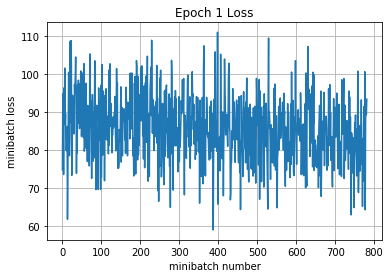

Validation
Epoch 1, Overall loss = 3.43 and accuracy of 0.153
EPOCH = %d 3
Iteration 0: with minibatch training loss = 1.13 and accuracy of 0.62
Iteration 100: with minibatch training loss = 1.67 and accuracy of 0.38
Iteration 200: with minibatch training loss = 1.12 and accuracy of 0.55
Iteration 300: with minibatch training loss = 1.29 and accuracy of 0.48
Iteration 400: with minibatch training loss = 1.01 and accuracy of 0.67
Iteration 500: with minibatch training loss = 1.45 and accuracy of 0.45
Iteration 600: with minibatch training loss = 1.08 and accuracy of 0.62
Iteration 700: with minibatch training loss = 1.16 and accuracy of 0.5
Epoch 1, Overall loss = 1.22 and accuracy of 0.56


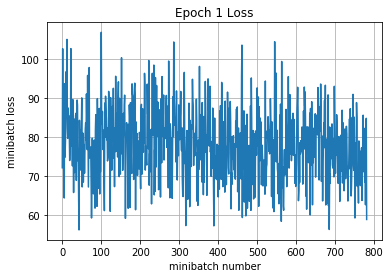

Validation
Epoch 1, Overall loss = 2.82 and accuracy of 0.214
EPOCH = %d 4
Iteration 0: with minibatch training loss = 1.06 and accuracy of 0.61
Iteration 100: with minibatch training loss = 1.26 and accuracy of 0.58
Iteration 200: with minibatch training loss = 1.08 and accuracy of 0.62
Iteration 300: with minibatch training loss = 1.39 and accuracy of 0.48
Iteration 400: with minibatch training loss = 1.07 and accuracy of 0.48
Iteration 500: with minibatch training loss = 1.26 and accuracy of 0.48
Iteration 600: with minibatch training loss = 1.17 and accuracy of 0.56
Iteration 700: with minibatch training loss = 1.27 and accuracy of 0.53
Epoch 1, Overall loss = 1.13 and accuracy of 0.594


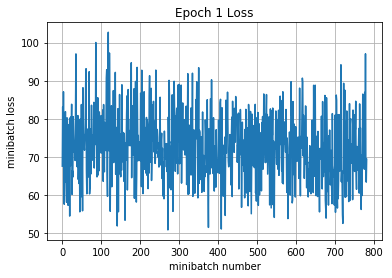

Validation
Epoch 1, Overall loss = 2.02 and accuracy of 0.355
EPOCH = %d 5
Iteration 0: with minibatch training loss = 0.963 and accuracy of 0.62
Iteration 100: with minibatch training loss = 1.28 and accuracy of 0.56
Iteration 200: with minibatch training loss = 0.94 and accuracy of 0.66
Iteration 300: with minibatch training loss = 1.04 and accuracy of 0.64
Iteration 400: with minibatch training loss = 1.07 and accuracy of 0.61
Iteration 500: with minibatch training loss = 1.06 and accuracy of 0.56
Iteration 600: with minibatch training loss = 1.11 and accuracy of 0.56
Iteration 700: with minibatch training loss = 1.23 and accuracy of 0.56
Epoch 1, Overall loss = 1.06 and accuracy of 0.62


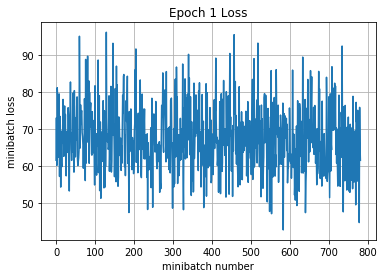

Validation
Epoch 1, Overall loss = 1.79 and accuracy of 0.409
EPOCH = %d 6
Iteration 0: with minibatch training loss = 1.05 and accuracy of 0.61
Iteration 100: with minibatch training loss = 1.07 and accuracy of 0.61
Iteration 200: with minibatch training loss = 0.97 and accuracy of 0.67
Iteration 300: with minibatch training loss = 1.12 and accuracy of 0.56
Iteration 400: with minibatch training loss = 1.27 and accuracy of 0.58
Iteration 500: with minibatch training loss = 1.01 and accuracy of 0.61
Iteration 600: with minibatch training loss = 0.917 and accuracy of 0.64
Iteration 700: with minibatch training loss = 0.914 and accuracy of 0.69
Epoch 1, Overall loss = 0.997 and accuracy of 0.645


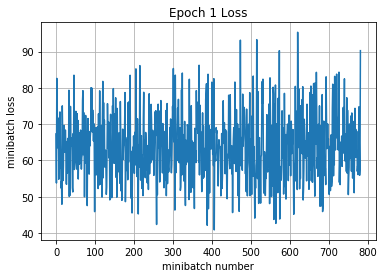

Validation
Epoch 1, Overall loss = 1.18 and accuracy of 0.574
EPOCH = %d 7
Iteration 0: with minibatch training loss = 0.808 and accuracy of 0.72
Iteration 100: with minibatch training loss = 0.871 and accuracy of 0.67
Iteration 200: with minibatch training loss = 0.97 and accuracy of 0.67
Iteration 300: with minibatch training loss = 1.05 and accuracy of 0.59
Iteration 400: with minibatch training loss = 0.905 and accuracy of 0.69
Iteration 500: with minibatch training loss = 0.931 and accuracy of 0.66
Iteration 600: with minibatch training loss = 1.05 and accuracy of 0.69
Iteration 700: with minibatch training loss = 1.11 and accuracy of 0.7
Epoch 1, Overall loss = 0.95 and accuracy of 0.662


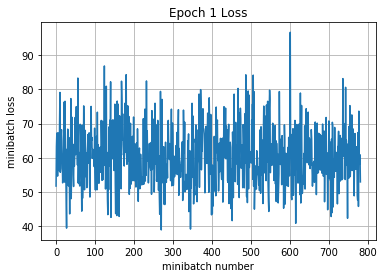

Validation
Epoch 1, Overall loss = 1.05 and accuracy of 0.618
EPOCH = %d 8
Iteration 0: with minibatch training loss = 0.807 and accuracy of 0.78
Iteration 100: with minibatch training loss = 0.632 and accuracy of 0.81
Iteration 200: with minibatch training loss = 0.736 and accuracy of 0.78
Iteration 300: with minibatch training loss = 0.852 and accuracy of 0.75
Iteration 400: with minibatch training loss = 1.09 and accuracy of 0.61
Iteration 500: with minibatch training loss = 1.06 and accuracy of 0.69
Iteration 600: with minibatch training loss = 0.83 and accuracy of 0.75
Iteration 700: with minibatch training loss = 1.02 and accuracy of 0.72
Epoch 1, Overall loss = 0.905 and accuracy of 0.678


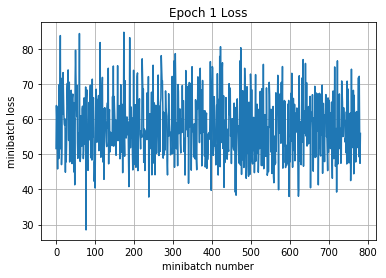

Validation
Epoch 1, Overall loss = 1.03 and accuracy of 0.64
EPOCH = %d 9
Iteration 0: with minibatch training loss = 0.882 and accuracy of 0.67
Iteration 100: with minibatch training loss = 0.821 and accuracy of 0.7
Iteration 200: with minibatch training loss = 1.03 and accuracy of 0.58
Iteration 300: with minibatch training loss = 0.814 and accuracy of 0.7
Iteration 400: with minibatch training loss = 0.871 and accuracy of 0.67
Iteration 500: with minibatch training loss = 0.917 and accuracy of 0.67
Iteration 600: with minibatch training loss = 0.755 and accuracy of 0.72
Iteration 700: with minibatch training loss = 0.829 and accuracy of 0.67
Epoch 1, Overall loss = 0.864 and accuracy of 0.694


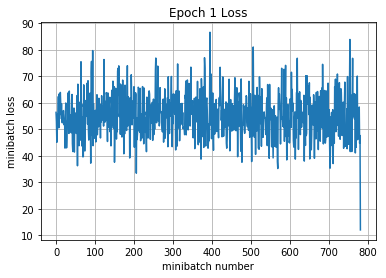

Validation
Epoch 1, Overall loss = 0.846 and accuracy of 0.7
EPOCH = %d 10
Iteration 0: with minibatch training loss = 0.895 and accuracy of 0.7
Iteration 100: with minibatch training loss = 0.914 and accuracy of 0.66
Iteration 200: with minibatch training loss = 0.741 and accuracy of 0.7
Iteration 300: with minibatch training loss = 0.766 and accuracy of 0.78
Iteration 400: with minibatch training loss = 0.765 and accuracy of 0.78
Iteration 500: with minibatch training loss = 0.854 and accuracy of 0.69
Iteration 600: with minibatch training loss = 0.852 and accuracy of 0.69
Iteration 700: with minibatch training loss = 0.815 and accuracy of 0.73
Epoch 1, Overall loss = 0.829 and accuracy of 0.704


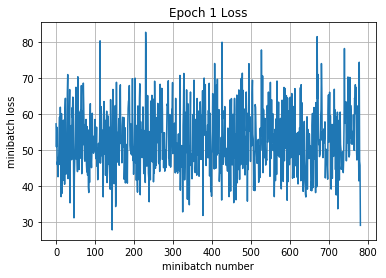

Validation
Epoch 1, Overall loss = 0.822 and accuracy of 0.714
EPOCH = %d 11
Iteration 0: with minibatch training loss = 0.831 and accuracy of 0.67
Iteration 100: with minibatch training loss = 0.831 and accuracy of 0.77
Iteration 200: with minibatch training loss = 0.546 and accuracy of 0.8
Iteration 300: with minibatch training loss = 0.669 and accuracy of 0.78
Iteration 400: with minibatch training loss = 0.556 and accuracy of 0.81
Iteration 500: with minibatch training loss = 0.868 and accuracy of 0.66
Iteration 600: with minibatch training loss = 0.66 and accuracy of 0.67
Iteration 700: with minibatch training loss = 0.718 and accuracy of 0.73
Epoch 1, Overall loss = 0.799 and accuracy of 0.717


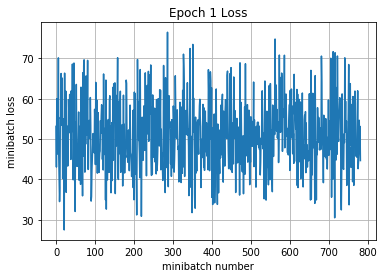

Validation
Epoch 1, Overall loss = 0.857 and accuracy of 0.71
EPOCH = %d 12
Iteration 0: with minibatch training loss = 0.578 and accuracy of 0.81
Iteration 100: with minibatch training loss = 0.764 and accuracy of 0.75
Iteration 200: with minibatch training loss = 1.03 and accuracy of 0.66
Iteration 300: with minibatch training loss = 0.773 and accuracy of 0.73
Iteration 400: with minibatch training loss = 0.65 and accuracy of 0.78
Iteration 500: with minibatch training loss = 0.717 and accuracy of 0.7
Iteration 600: with minibatch training loss = 0.88 and accuracy of 0.72
Iteration 700: with minibatch training loss = 0.873 and accuracy of 0.69
Epoch 1, Overall loss = 0.765 and accuracy of 0.73


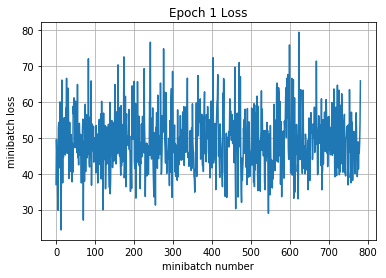

Validation
Epoch 1, Overall loss = 0.871 and accuracy of 0.693
EPOCH = %d 13
Iteration 0: with minibatch training loss = 0.869 and accuracy of 0.67
Iteration 100: with minibatch training loss = 0.876 and accuracy of 0.75
Iteration 200: with minibatch training loss = 0.917 and accuracy of 0.72
Iteration 300: with minibatch training loss = 0.487 and accuracy of 0.88
Iteration 400: with minibatch training loss = 0.627 and accuracy of 0.75
Iteration 500: with minibatch training loss = 0.75 and accuracy of 0.73
Iteration 600: with minibatch training loss = 0.489 and accuracy of 0.81
Iteration 700: with minibatch training loss = 0.819 and accuracy of 0.7
Epoch 1, Overall loss = 0.739 and accuracy of 0.736


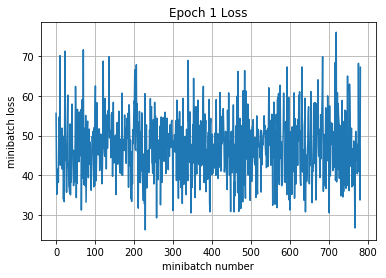

Validation
Epoch 1, Overall loss = 0.842 and accuracy of 0.705
EPOCH = %d 14
Iteration 0: with minibatch training loss = 0.758 and accuracy of 0.67
Iteration 100: with minibatch training loss = 0.51 and accuracy of 0.89
Iteration 200: with minibatch training loss = 0.659 and accuracy of 0.72
Iteration 300: with minibatch training loss = 0.877 and accuracy of 0.64
Iteration 400: with minibatch training loss = 0.616 and accuracy of 0.77
Iteration 500: with minibatch training loss = 0.512 and accuracy of 0.81
Iteration 600: with minibatch training loss = 0.697 and accuracy of 0.78
Iteration 700: with minibatch training loss = 0.67 and accuracy of 0.73
Epoch 1, Overall loss = 0.714 and accuracy of 0.747


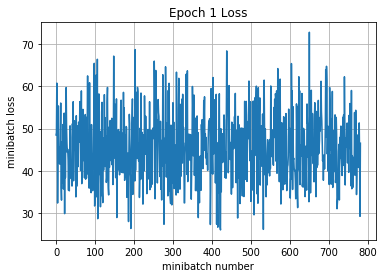

Validation
Epoch 1, Overall loss = 0.863 and accuracy of 0.701
EPOCH = %d 15
Iteration 0: with minibatch training loss = 0.745 and accuracy of 0.66
Iteration 100: with minibatch training loss = 0.524 and accuracy of 0.77
Iteration 200: with minibatch training loss = 0.788 and accuracy of 0.73
Iteration 300: with minibatch training loss = 0.539 and accuracy of 0.81
Iteration 400: with minibatch training loss = 0.783 and accuracy of 0.69
Iteration 500: with minibatch training loss = 0.627 and accuracy of 0.72
Iteration 600: with minibatch training loss = 0.743 and accuracy of 0.75
Iteration 700: with minibatch training loss = 0.821 and accuracy of 0.7
Epoch 1, Overall loss = 0.692 and accuracy of 0.753


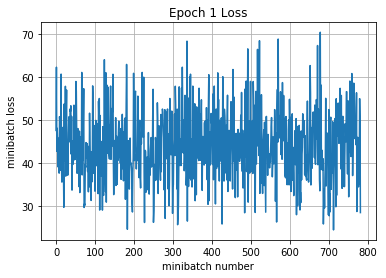

Validation
Epoch 1, Overall loss = 0.844 and accuracy of 0.713
EPOCH = %d 16
Iteration 0: with minibatch training loss = 0.769 and accuracy of 0.73
Iteration 100: with minibatch training loss = 0.512 and accuracy of 0.81
Iteration 200: with minibatch training loss = 0.683 and accuracy of 0.75
Iteration 300: with minibatch training loss = 0.794 and accuracy of 0.72
Iteration 400: with minibatch training loss = 0.735 and accuracy of 0.7
Iteration 500: with minibatch training loss = 0.653 and accuracy of 0.75
Iteration 600: with minibatch training loss = 0.641 and accuracy of 0.8
Iteration 700: with minibatch training loss = 0.574 and accuracy of 0.8
Epoch 1, Overall loss = 0.666 and accuracy of 0.764


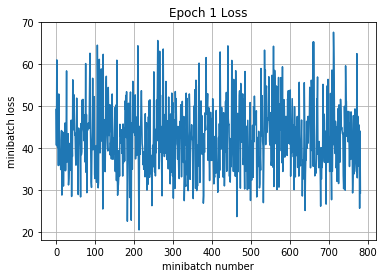

Validation
Epoch 1, Overall loss = 0.69 and accuracy of 0.758
EPOCH = %d 17
Iteration 0: with minibatch training loss = 0.469 and accuracy of 0.8
Iteration 100: with minibatch training loss = 0.788 and accuracy of 0.8
Iteration 200: with minibatch training loss = 0.698 and accuracy of 0.67
Iteration 300: with minibatch training loss = 0.518 and accuracy of 0.83
Iteration 400: with minibatch training loss = 0.512 and accuracy of 0.75
Iteration 500: with minibatch training loss = 0.59 and accuracy of 0.84
Iteration 600: with minibatch training loss = 0.63 and accuracy of 0.75
Iteration 700: with minibatch training loss = 0.608 and accuracy of 0.78
Epoch 1, Overall loss = 0.649 and accuracy of 0.769


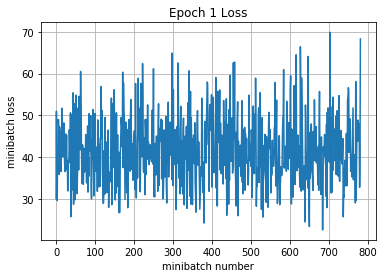

Validation
Epoch 1, Overall loss = 0.769 and accuracy of 0.734
EPOCH = %d 18
Iteration 0: with minibatch training loss = 0.415 and accuracy of 0.91
Iteration 100: with minibatch training loss = 0.725 and accuracy of 0.77
Iteration 200: with minibatch training loss = 0.515 and accuracy of 0.84
Iteration 300: with minibatch training loss = 0.806 and accuracy of 0.7
Iteration 400: with minibatch training loss = 0.676 and accuracy of 0.78
Iteration 500: with minibatch training loss = 0.682 and accuracy of 0.72
Iteration 600: with minibatch training loss = 0.515 and accuracy of 0.8
Iteration 700: with minibatch training loss = 0.56 and accuracy of 0.75
Epoch 1, Overall loss = 0.623 and accuracy of 0.778


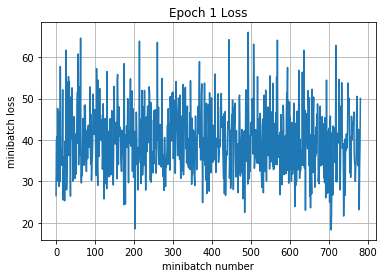

Validation
Epoch 1, Overall loss = 0.863 and accuracy of 0.704
EPOCH = %d 19
Iteration 0: with minibatch training loss = 0.712 and accuracy of 0.73
Iteration 100: with minibatch training loss = 0.531 and accuracy of 0.83
Iteration 200: with minibatch training loss = 0.506 and accuracy of 0.81
Iteration 300: with minibatch training loss = 0.666 and accuracy of 0.78
Iteration 400: with minibatch training loss = 1.12 and accuracy of 0.67
Iteration 500: with minibatch training loss = 0.525 and accuracy of 0.81
Iteration 600: with minibatch training loss = 0.603 and accuracy of 0.77
Iteration 700: with minibatch training loss = 0.454 and accuracy of 0.88
Epoch 1, Overall loss = 0.611 and accuracy of 0.783


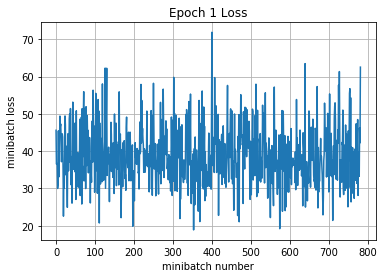

Validation
Epoch 1, Overall loss = 0.984 and accuracy of 0.684
EPOCH = %d 20
Iteration 0: with minibatch training loss = 0.557 and accuracy of 0.83
Iteration 100: with minibatch training loss = 0.647 and accuracy of 0.78
Iteration 200: with minibatch training loss = 0.615 and accuracy of 0.81
Iteration 300: with minibatch training loss = 0.625 and accuracy of 0.72
Iteration 400: with minibatch training loss = 0.653 and accuracy of 0.73
Iteration 500: with minibatch training loss = 0.512 and accuracy of 0.84
Iteration 600: with minibatch training loss = 0.438 and accuracy of 0.86
Iteration 700: with minibatch training loss = 0.476 and accuracy of 0.83
Epoch 1, Overall loss = 0.592 and accuracy of 0.789


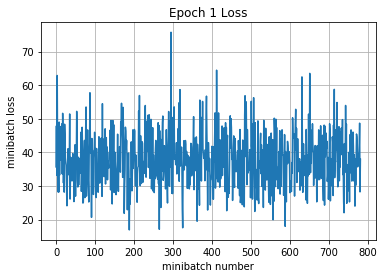

Validation
Epoch 1, Overall loss = 0.724 and accuracy of 0.749
EPOCH = %d 21
Iteration 0: with minibatch training loss = 0.697 and accuracy of 0.7
Iteration 100: with minibatch training loss = 0.65 and accuracy of 0.77
Iteration 200: with minibatch training loss = 0.571 and accuracy of 0.78
Iteration 300: with minibatch training loss = 0.602 and accuracy of 0.84
Iteration 400: with minibatch training loss = 0.406 and accuracy of 0.88
Iteration 500: with minibatch training loss = 0.625 and accuracy of 0.81
Iteration 600: with minibatch training loss = 0.528 and accuracy of 0.83
Iteration 700: with minibatch training loss = 0.463 and accuracy of 0.86
Epoch 1, Overall loss = 0.572 and accuracy of 0.796


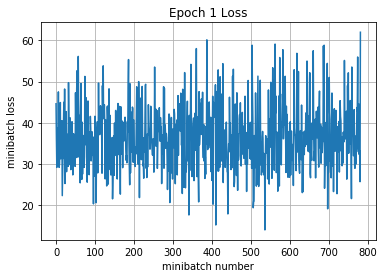

Validation
Epoch 1, Overall loss = 0.819 and accuracy of 0.723
EPOCH = %d 22
Iteration 0: with minibatch training loss = 0.657 and accuracy of 0.78
Iteration 100: with minibatch training loss = 0.363 and accuracy of 0.86
Iteration 200: with minibatch training loss = 0.435 and accuracy of 0.84
Iteration 300: with minibatch training loss = 0.704 and accuracy of 0.73
Iteration 400: with minibatch training loss = 0.507 and accuracy of 0.8
Iteration 500: with minibatch training loss = 0.587 and accuracy of 0.81
Iteration 600: with minibatch training loss = 0.759 and accuracy of 0.69
Iteration 700: with minibatch training loss = 0.738 and accuracy of 0.72
Epoch 1, Overall loss = 0.55 and accuracy of 0.803


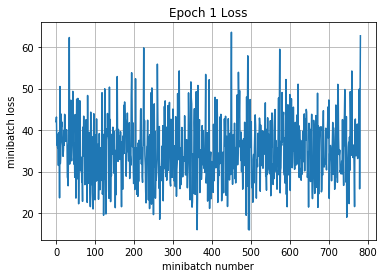

Validation
Epoch 1, Overall loss = 0.694 and accuracy of 0.764
EPOCH = %d 23
Iteration 0: with minibatch training loss = 0.664 and accuracy of 0.81
Iteration 100: with minibatch training loss = 0.695 and accuracy of 0.77
Iteration 200: with minibatch training loss = 0.538 and accuracy of 0.78
Iteration 300: with minibatch training loss = 0.323 and accuracy of 0.88
Iteration 400: with minibatch training loss = 0.485 and accuracy of 0.75
Iteration 500: with minibatch training loss = 0.321 and accuracy of 0.88
Iteration 600: with minibatch training loss = 0.425 and accuracy of 0.83
Iteration 700: with minibatch training loss = 0.416 and accuracy of 0.84
Epoch 1, Overall loss = 0.536 and accuracy of 0.809


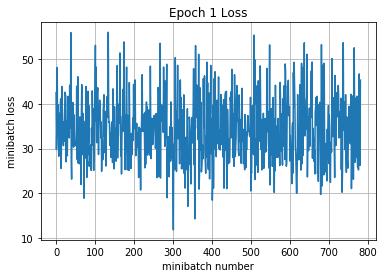

Validation
Epoch 1, Overall loss = 0.74 and accuracy of 0.744
EPOCH = %d 24
Iteration 0: with minibatch training loss = 0.533 and accuracy of 0.77
Iteration 100: with minibatch training loss = 0.486 and accuracy of 0.8
Iteration 200: with minibatch training loss = 0.528 and accuracy of 0.83
Iteration 300: with minibatch training loss = 0.632 and accuracy of 0.77
Iteration 400: with minibatch training loss = 0.563 and accuracy of 0.77
Iteration 500: with minibatch training loss = 0.835 and accuracy of 0.75
Iteration 600: with minibatch training loss = 0.364 and accuracy of 0.86
Iteration 700: with minibatch training loss = 0.659 and accuracy of 0.77
Epoch 1, Overall loss = 0.522 and accuracy of 0.815


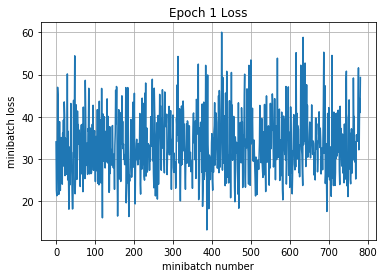

Validation
Epoch 1, Overall loss = 0.861 and accuracy of 0.713
EPOCH = %d 25
Iteration 0: with minibatch training loss = 0.362 and accuracy of 0.92
Iteration 100: with minibatch training loss = 0.525 and accuracy of 0.83
Iteration 200: with minibatch training loss = 0.334 and accuracy of 0.91
Iteration 300: with minibatch training loss = 0.589 and accuracy of 0.81
Iteration 400: with minibatch training loss = 0.495 and accuracy of 0.84
Iteration 500: with minibatch training loss = 0.549 and accuracy of 0.83
Iteration 600: with minibatch training loss = 0.694 and accuracy of 0.78
Iteration 700: with minibatch training loss = 0.459 and accuracy of 0.86
Epoch 1, Overall loss = 0.508 and accuracy of 0.82


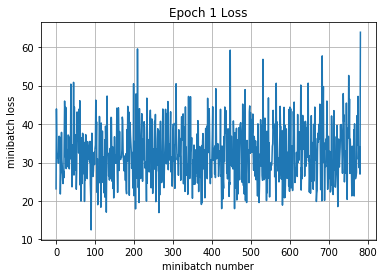

Validation
Epoch 1, Overall loss = 0.791 and accuracy of 0.739
EPOCH = %d 26
Iteration 0: with minibatch training loss = 0.368 and accuracy of 0.83
Iteration 100: with minibatch training loss = 0.415 and accuracy of 0.92
Iteration 200: with minibatch training loss = 0.365 and accuracy of 0.91
Iteration 300: with minibatch training loss = 0.561 and accuracy of 0.78
Iteration 400: with minibatch training loss = 0.691 and accuracy of 0.77
Iteration 500: with minibatch training loss = 0.322 and accuracy of 0.91
Iteration 600: with minibatch training loss = 0.388 and accuracy of 0.86
Iteration 700: with minibatch training loss = 0.522 and accuracy of 0.8
Epoch 1, Overall loss = 0.492 and accuracy of 0.826


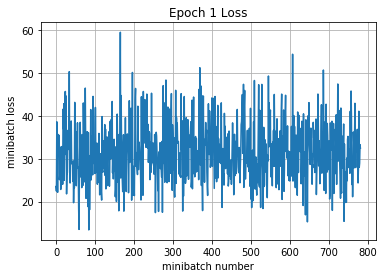

Validation
Epoch 1, Overall loss = 0.628 and accuracy of 0.785
EPOCH = %d 27
Iteration 0: with minibatch training loss = 0.356 and accuracy of 0.84
Iteration 100: with minibatch training loss = 0.375 and accuracy of 0.84
Iteration 200: with minibatch training loss = 0.384 and accuracy of 0.88
Iteration 300: with minibatch training loss = 0.405 and accuracy of 0.86
Iteration 400: with minibatch training loss = 0.56 and accuracy of 0.8
Iteration 500: with minibatch training loss = 0.555 and accuracy of 0.78
Iteration 600: with minibatch training loss = 0.583 and accuracy of 0.8
Iteration 700: with minibatch training loss = 0.422 and accuracy of 0.89
Epoch 1, Overall loss = 0.478 and accuracy of 0.829


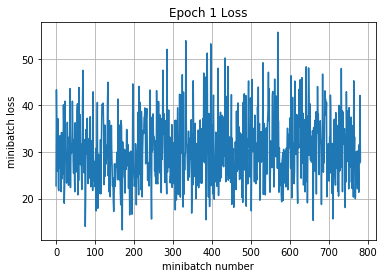

Validation
Epoch 1, Overall loss = 0.68 and accuracy of 0.764
EPOCH = %d 28
Iteration 0: with minibatch training loss = 0.363 and accuracy of 0.89
Iteration 100: with minibatch training loss = 0.568 and accuracy of 0.78
Iteration 200: with minibatch training loss = 0.606 and accuracy of 0.77
Iteration 300: with minibatch training loss = 0.501 and accuracy of 0.86
Iteration 400: with minibatch training loss = 0.333 and accuracy of 0.88
Iteration 500: with minibatch training loss = 0.632 and accuracy of 0.72
Iteration 600: with minibatch training loss = 0.433 and accuracy of 0.89
Iteration 700: with minibatch training loss = 0.428 and accuracy of 0.81
Epoch 1, Overall loss = 0.468 and accuracy of 0.834


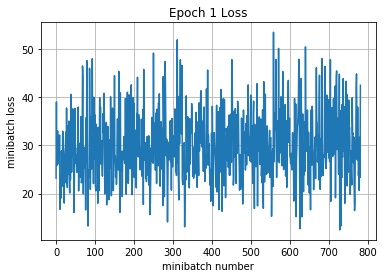

Validation
Epoch 1, Overall loss = 0.72 and accuracy of 0.768
EPOCH = %d 29
Iteration 0: with minibatch training loss = 0.549 and accuracy of 0.8
Iteration 100: with minibatch training loss = 0.462 and accuracy of 0.88
Iteration 200: with minibatch training loss = 0.457 and accuracy of 0.84
Iteration 300: with minibatch training loss = 0.415 and accuracy of 0.84
Iteration 400: with minibatch training loss = 0.353 and accuracy of 0.88
Iteration 500: with minibatch training loss = 0.524 and accuracy of 0.86
Iteration 600: with minibatch training loss = 0.71 and accuracy of 0.77
Iteration 700: with minibatch training loss = 0.519 and accuracy of 0.81
Epoch 1, Overall loss = 0.448 and accuracy of 0.84


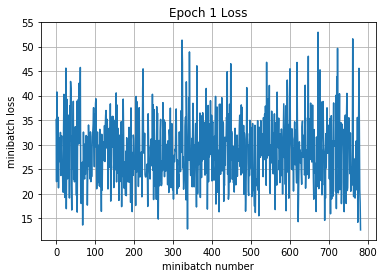

Validation
Epoch 1, Overall loss = 0.62 and accuracy of 0.793
EPOCH = %d 30
Iteration 0: with minibatch training loss = 0.728 and accuracy of 0.72
Iteration 100: with minibatch training loss = 0.431 and accuracy of 0.84
Iteration 200: with minibatch training loss = 0.498 and accuracy of 0.83
Iteration 300: with minibatch training loss = 0.352 and accuracy of 0.92
Iteration 400: with minibatch training loss = 0.529 and accuracy of 0.81
Iteration 500: with minibatch training loss = 0.46 and accuracy of 0.84
Iteration 600: with minibatch training loss = 0.46 and accuracy of 0.88
Iteration 700: with minibatch training loss = 0.524 and accuracy of 0.78
Epoch 1, Overall loss = 0.434 and accuracy of 0.845


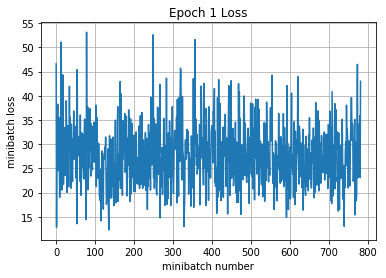

Validation
Epoch 1, Overall loss = 0.813 and accuracy of 0.732
EPOCH = %d 31
Iteration 0: with minibatch training loss = 0.474 and accuracy of 0.83
Iteration 100: with minibatch training loss = 0.274 and accuracy of 0.94
Iteration 200: with minibatch training loss = 0.253 and accuracy of 0.92
Iteration 300: with minibatch training loss = 0.376 and accuracy of 0.88
Iteration 400: with minibatch training loss = 0.565 and accuracy of 0.83
Iteration 500: with minibatch training loss = 0.381 and accuracy of 0.84
Iteration 600: with minibatch training loss = 0.558 and accuracy of 0.78
Iteration 700: with minibatch training loss = 0.51 and accuracy of 0.8
Epoch 1, Overall loss = 0.428 and accuracy of 0.847


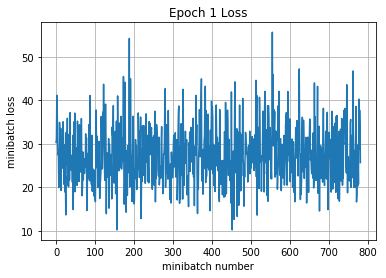

Validation
Epoch 1, Overall loss = 0.834 and accuracy of 0.735
EPOCH = %d 32
Iteration 0: with minibatch training loss = 0.581 and accuracy of 0.81
Iteration 100: with minibatch training loss = 0.332 and accuracy of 0.91
Iteration 200: with minibatch training loss = 0.52 and accuracy of 0.83
Iteration 300: with minibatch training loss = 0.309 and accuracy of 0.89
Iteration 400: with minibatch training loss = 0.339 and accuracy of 0.89
Iteration 500: with minibatch training loss = 0.341 and accuracy of 0.91
Iteration 600: with minibatch training loss = 0.437 and accuracy of 0.83
Iteration 700: with minibatch training loss = 0.364 and accuracy of 0.88
Epoch 1, Overall loss = 0.417 and accuracy of 0.85


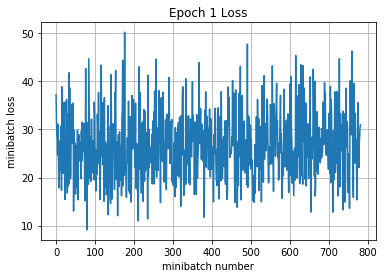

Validation
Epoch 1, Overall loss = 1.09 and accuracy of 0.69
EPOCH = %d 33
Iteration 0: with minibatch training loss = 0.293 and accuracy of 0.91
Iteration 100: with minibatch training loss = 0.509 and accuracy of 0.83
Iteration 200: with minibatch training loss = 0.289 and accuracy of 0.86
Iteration 300: with minibatch training loss = 0.233 and accuracy of 0.94
Iteration 400: with minibatch training loss = 0.49 and accuracy of 0.84
Iteration 500: with minibatch training loss = 0.389 and accuracy of 0.91
Iteration 600: with minibatch training loss = 0.378 and accuracy of 0.84
Iteration 700: with minibatch training loss = 0.426 and accuracy of 0.89
Epoch 1, Overall loss = 0.398 and accuracy of 0.858


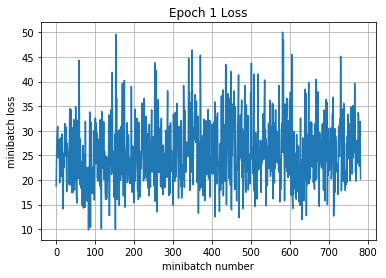

Validation
Epoch 1, Overall loss = 0.669 and accuracy of 0.779
EPOCH = %d 34
Iteration 0: with minibatch training loss = 0.342 and accuracy of 0.88
Iteration 100: with minibatch training loss = 0.456 and accuracy of 0.83
Iteration 200: with minibatch training loss = 0.303 and accuracy of 0.92
Iteration 300: with minibatch training loss = 0.372 and accuracy of 0.88
Iteration 400: with minibatch training loss = 0.409 and accuracy of 0.89
Iteration 500: with minibatch training loss = 0.245 and accuracy of 0.91
Iteration 600: with minibatch training loss = 0.446 and accuracy of 0.84
Iteration 700: with minibatch training loss = 0.398 and accuracy of 0.89
Epoch 1, Overall loss = 0.383 and accuracy of 0.864


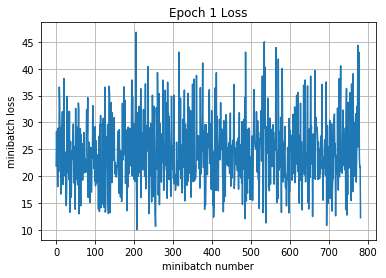

Validation
Epoch 1, Overall loss = 0.804 and accuracy of 0.759
EPOCH = %d 35
Iteration 0: with minibatch training loss = 0.33 and accuracy of 0.84
Iteration 100: with minibatch training loss = 0.23 and accuracy of 0.95
Iteration 200: with minibatch training loss = 0.3 and accuracy of 0.86
Iteration 300: with minibatch training loss = 0.346 and accuracy of 0.88
Iteration 400: with minibatch training loss = 0.382 and accuracy of 0.88
Iteration 500: with minibatch training loss = 0.378 and accuracy of 0.84
Iteration 600: with minibatch training loss = 0.388 and accuracy of 0.8
Iteration 700: with minibatch training loss = 0.338 and accuracy of 0.91
Epoch 1, Overall loss = 0.374 and accuracy of 0.867


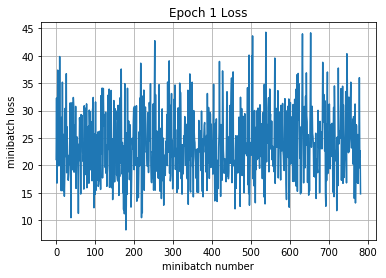

Validation
Epoch 1, Overall loss = 0.698 and accuracy of 0.772
EPOCH = %d 36
Iteration 0: with minibatch training loss = 0.469 and accuracy of 0.84
Iteration 100: with minibatch training loss = 0.286 and accuracy of 0.92
Iteration 200: with minibatch training loss = 0.327 and accuracy of 0.94
Iteration 300: with minibatch training loss = 0.35 and accuracy of 0.88
Iteration 400: with minibatch training loss = 0.289 and accuracy of 0.91
Iteration 500: with minibatch training loss = 0.428 and accuracy of 0.83
Iteration 600: with minibatch training loss = 0.258 and accuracy of 0.91
Iteration 700: with minibatch training loss = 0.391 and accuracy of 0.88
Epoch 1, Overall loss = 0.368 and accuracy of 0.868


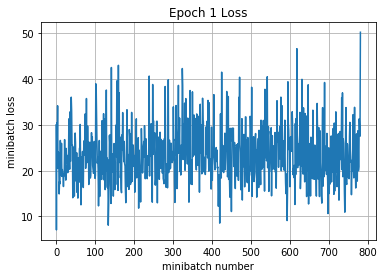

Validation
Epoch 1, Overall loss = 0.689 and accuracy of 0.78
EPOCH = %d 37
Iteration 0: with minibatch training loss = 0.425 and accuracy of 0.88
Iteration 100: with minibatch training loss = 0.522 and accuracy of 0.78
Iteration 200: with minibatch training loss = 0.44 and accuracy of 0.8
Iteration 300: with minibatch training loss = 0.292 and accuracy of 0.88
Iteration 400: with minibatch training loss = 0.245 and accuracy of 0.91
Iteration 500: with minibatch training loss = 0.427 and accuracy of 0.83
Iteration 600: with minibatch training loss = 0.618 and accuracy of 0.77
Iteration 700: with minibatch training loss = 0.329 and accuracy of 0.84
Epoch 1, Overall loss = 0.36 and accuracy of 0.869


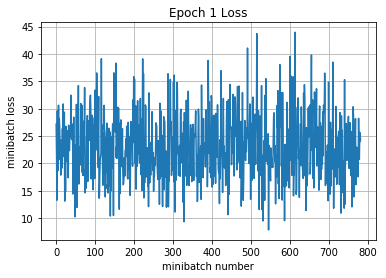

Validation
Epoch 1, Overall loss = 0.706 and accuracy of 0.779
EPOCH = %d 38
Iteration 0: with minibatch training loss = 0.375 and accuracy of 0.88
Iteration 100: with minibatch training loss = 0.349 and accuracy of 0.81
Iteration 200: with minibatch training loss = 0.461 and accuracy of 0.8
Iteration 300: with minibatch training loss = 0.34 and accuracy of 0.89
Iteration 400: with minibatch training loss = 0.319 and accuracy of 0.89
Iteration 500: with minibatch training loss = 0.212 and accuracy of 0.92
Iteration 600: with minibatch training loss = 0.251 and accuracy of 0.92
Iteration 700: with minibatch training loss = 0.267 and accuracy of 0.91
Epoch 1, Overall loss = 0.353 and accuracy of 0.872


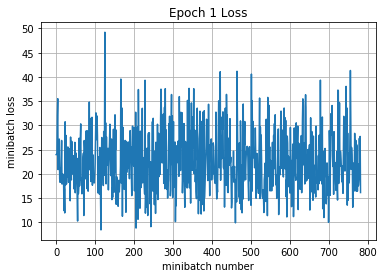

Validation
Epoch 1, Overall loss = 0.729 and accuracy of 0.769
EPOCH = %d 39
Iteration 0: with minibatch training loss = 0.261 and accuracy of 0.92
Iteration 100: with minibatch training loss = 0.337 and accuracy of 0.84
Iteration 200: with minibatch training loss = 0.372 and accuracy of 0.88
Iteration 300: with minibatch training loss = 0.244 and accuracy of 0.94
Iteration 400: with minibatch training loss = 0.524 and accuracy of 0.83
Iteration 500: with minibatch training loss = 0.319 and accuracy of 0.89
Iteration 600: with minibatch training loss = 0.313 and accuracy of 0.88
Iteration 700: with minibatch training loss = 0.319 and accuracy of 0.89
Epoch 1, Overall loss = 0.341 and accuracy of 0.877


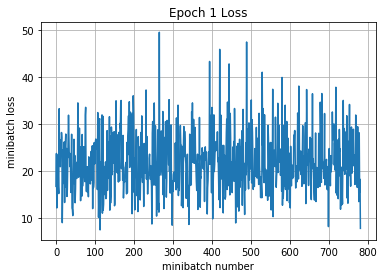

Validation
Epoch 1, Overall loss = 0.894 and accuracy of 0.744
EPOCH = %d 40
Iteration 0: with minibatch training loss = 0.326 and accuracy of 0.86
Iteration 100: with minibatch training loss = 0.372 and accuracy of 0.86
Iteration 200: with minibatch training loss = 0.287 and accuracy of 0.89
Iteration 300: with minibatch training loss = 0.375 and accuracy of 0.86
Iteration 400: with minibatch training loss = 0.606 and accuracy of 0.8
Iteration 500: with minibatch training loss = 0.347 and accuracy of 0.89
Iteration 600: with minibatch training loss = 0.287 and accuracy of 0.88
Iteration 700: with minibatch training loss = 0.417 and accuracy of 0.84
Epoch 1, Overall loss = 0.33 and accuracy of 0.882


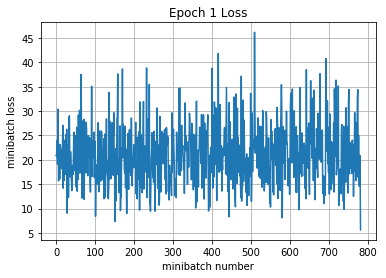

Validation
Epoch 1, Overall loss = 0.824 and accuracy of 0.752
EPOCH = %d 41
Iteration 0: with minibatch training loss = 0.313 and accuracy of 0.89
Iteration 100: with minibatch training loss = 0.426 and accuracy of 0.88
Iteration 200: with minibatch training loss = 0.164 and accuracy of 0.97
Iteration 300: with minibatch training loss = 0.333 and accuracy of 0.88
Iteration 400: with minibatch training loss = 0.313 and accuracy of 0.84
Iteration 500: with minibatch training loss = 0.368 and accuracy of 0.84
Iteration 600: with minibatch training loss = 0.173 and accuracy of 0.94
Iteration 700: with minibatch training loss = 0.171 and accuracy of 0.92
Epoch 1, Overall loss = 0.32 and accuracy of 0.884


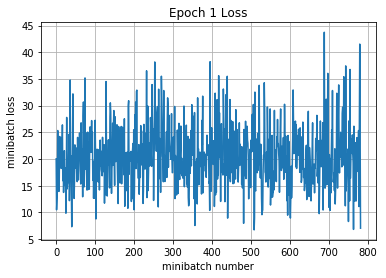

Validation
Epoch 1, Overall loss = 0.664 and accuracy of 0.793
EPOCH = %d 42
Iteration 0: with minibatch training loss = 0.304 and accuracy of 0.89
Iteration 100: with minibatch training loss = 0.381 and accuracy of 0.84
Iteration 200: with minibatch training loss = 0.34 and accuracy of 0.84
Iteration 300: with minibatch training loss = 0.168 and accuracy of 0.95
Iteration 400: with minibatch training loss = 0.288 and accuracy of 0.91
Iteration 500: with minibatch training loss = 0.388 and accuracy of 0.83
Iteration 600: with minibatch training loss = 0.398 and accuracy of 0.88
Iteration 700: with minibatch training loss = 0.3 and accuracy of 0.86
Epoch 1, Overall loss = 0.317 and accuracy of 0.886


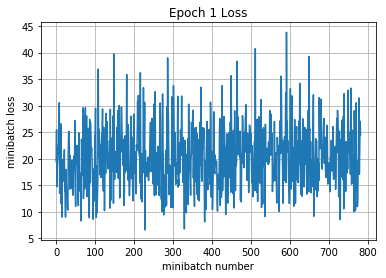

Validation
Epoch 1, Overall loss = 0.717 and accuracy of 0.772
EPOCH = %d 43
Iteration 0: with minibatch training loss = 0.275 and accuracy of 0.94
Iteration 100: with minibatch training loss = 0.216 and accuracy of 0.91
Iteration 200: with minibatch training loss = 0.334 and accuracy of 0.88
Iteration 300: with minibatch training loss = 0.33 and accuracy of 0.86
Iteration 400: with minibatch training loss = 0.246 and accuracy of 0.94
Iteration 500: with minibatch training loss = 0.337 and accuracy of 0.86
Iteration 600: with minibatch training loss = 0.298 and accuracy of 0.92
Iteration 700: with minibatch training loss = 0.205 and accuracy of 0.95
Epoch 1, Overall loss = 0.306 and accuracy of 0.888


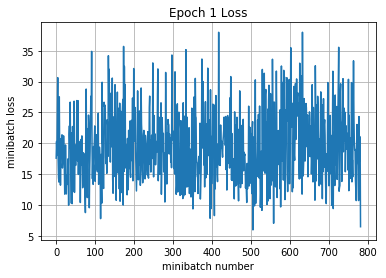

Validation
Epoch 1, Overall loss = 0.688 and accuracy of 0.787
EPOCH = %d 44
Iteration 0: with minibatch training loss = 0.194 and accuracy of 0.92
Iteration 100: with minibatch training loss = 0.364 and accuracy of 0.89
Iteration 200: with minibatch training loss = 0.323 and accuracy of 0.86
Iteration 300: with minibatch training loss = 0.213 and accuracy of 0.89
Iteration 400: with minibatch training loss = 0.273 and accuracy of 0.89
Iteration 500: with minibatch training loss = 0.512 and accuracy of 0.8
Iteration 600: with minibatch training loss = 0.315 and accuracy of 0.89
Iteration 700: with minibatch training loss = 0.449 and accuracy of 0.88
Epoch 1, Overall loss = 0.301 and accuracy of 0.892


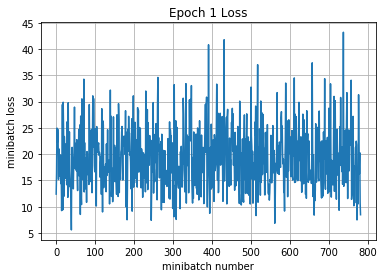

Validation
Epoch 1, Overall loss = 0.687 and accuracy of 0.789
EPOCH = %d 45
Iteration 0: with minibatch training loss = 0.248 and accuracy of 0.91
Iteration 100: with minibatch training loss = 0.375 and accuracy of 0.88
Iteration 200: with minibatch training loss = 0.309 and accuracy of 0.91
Iteration 300: with minibatch training loss = 0.423 and accuracy of 0.81
Iteration 400: with minibatch training loss = 0.338 and accuracy of 0.86
Iteration 500: with minibatch training loss = 0.389 and accuracy of 0.88
Iteration 600: with minibatch training loss = 0.235 and accuracy of 0.92
Iteration 700: with minibatch training loss = 0.306 and accuracy of 0.88
Epoch 1, Overall loss = 0.29 and accuracy of 0.897


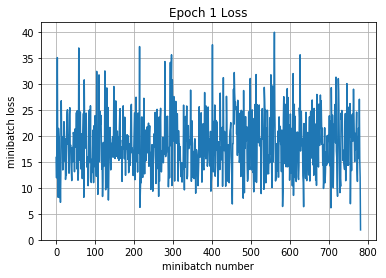

Validation
Epoch 1, Overall loss = 0.825 and accuracy of 0.768
EPOCH = %d 46
Iteration 0: with minibatch training loss = 0.221 and accuracy of 0.92
Iteration 100: with minibatch training loss = 0.157 and accuracy of 0.94
Iteration 200: with minibatch training loss = 0.265 and accuracy of 0.91
Iteration 300: with minibatch training loss = 0.336 and accuracy of 0.88
Iteration 400: with minibatch training loss = 0.207 and accuracy of 0.92
Iteration 500: with minibatch training loss = 0.241 and accuracy of 0.92
Iteration 600: with minibatch training loss = 0.259 and accuracy of 0.92
Iteration 700: with minibatch training loss = 0.361 and accuracy of 0.88
Epoch 1, Overall loss = 0.287 and accuracy of 0.898


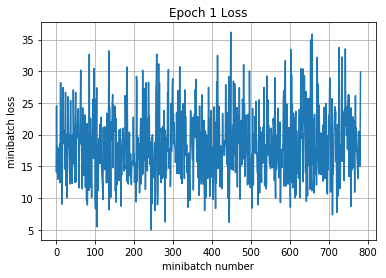

Validation
Epoch 1, Overall loss = 0.612 and accuracy of 0.808
EPOCH = %d 47
Iteration 0: with minibatch training loss = 0.277 and accuracy of 0.89
Iteration 100: with minibatch training loss = 0.326 and accuracy of 0.91
Iteration 200: with minibatch training loss = 0.281 and accuracy of 0.91
Iteration 300: with minibatch training loss = 0.274 and accuracy of 0.89
Iteration 400: with minibatch training loss = 0.143 and accuracy of 0.95
Iteration 500: with minibatch training loss = 0.228 and accuracy of 0.95
Iteration 600: with minibatch training loss = 0.27 and accuracy of 0.89
Iteration 700: with minibatch training loss = 0.326 and accuracy of 0.84
Epoch 1, Overall loss = 0.277 and accuracy of 0.901


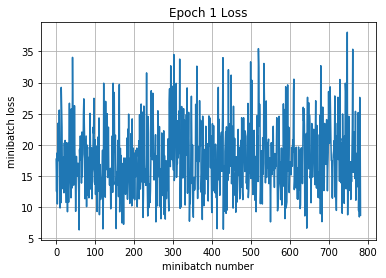

Validation
Epoch 1, Overall loss = 0.713 and accuracy of 0.783
EPOCH = %d 48
Iteration 0: with minibatch training loss = 0.23 and accuracy of 0.91
Iteration 100: with minibatch training loss = 0.209 and accuracy of 0.94
Iteration 200: with minibatch training loss = 0.433 and accuracy of 0.83
Iteration 300: with minibatch training loss = 0.245 and accuracy of 0.92
Iteration 400: with minibatch training loss = 0.29 and accuracy of 0.89
Iteration 500: with minibatch training loss = 0.176 and accuracy of 0.94
Iteration 600: with minibatch training loss = 0.402 and accuracy of 0.88
Iteration 700: with minibatch training loss = 0.216 and accuracy of 0.92
Epoch 1, Overall loss = 0.274 and accuracy of 0.903


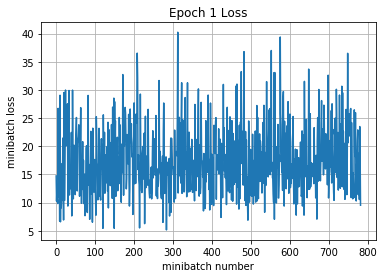

Validation
Epoch 1, Overall loss = 0.636 and accuracy of 0.803
EPOCH = %d 49
Iteration 0: with minibatch training loss = 0.298 and accuracy of 0.88
Iteration 100: with minibatch training loss = 0.338 and accuracy of 0.92
Iteration 200: with minibatch training loss = 0.414 and accuracy of 0.84
Iteration 300: with minibatch training loss = 0.27 and accuracy of 0.91
Iteration 400: with minibatch training loss = 0.277 and accuracy of 0.92
Iteration 500: with minibatch training loss = 0.178 and accuracy of 0.94
Iteration 600: with minibatch training loss = 0.344 and accuracy of 0.89
Iteration 700: with minibatch training loss = 0.592 and accuracy of 0.8
Epoch 1, Overall loss = 0.262 and accuracy of 0.905


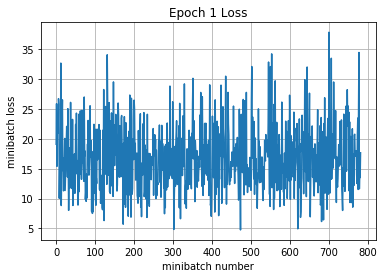

Validation
Epoch 1, Overall loss = 0.723 and accuracy of 0.777


In [29]:
sess = tf.Session()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
print('Training')
num_epochs = 50
for i in range(num_epochs):
    print ("EPOCH = %d",i)
    run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True,drop_o = 0.6)
    print('Validation')
    run_model(sess,y_out,mean_loss,X_test,y_test,1,64)
    saver.save(sess,'../models/cifar10_classification/classification_cifar10_model_new')
    #run_model(sess,y_value,mean_loss2,X_test,y_test,1,64)

In [37]:
### Using the above trained model

sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess,'../models/cifar10_classification/classification_cifar10_model')

batch_size = 64
num_epochs = 10000//64
num_correct = 0
num_total = 0
for i in range(num_epochs):
    X_test_samp = X_test[i*64:(i+1)*64,:,:,:]
    Y_test_samp = y_test[i*64:(i+1)*64]
    feed_dict ={X:X_test_samp,y:Y_test_samp,is_training:False,dropout:1}
    prediction = sess.run([y_out],feed_dict)
    
    y_pred = np.argmax(prediction[0],axis = 1)
    #print (y_pred.shape)
    #print()
    num_total += batch_size
    num_correct += sum(np.equal(y_pred, Y_test_samp))
print (num_correct/num_total)
    


INFO:tensorflow:Restoring parameters from ../models/cifar10_classification/classification_cifar10_model


INFO:tensorflow:Restoring parameters from ../models/cifar10_classification/classification_cifar10_model


0.777644230769


In [38]:
yuv_converter = np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],
                                  [0.615,-0.514999,-0.10001]])
inv_mat  = np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]])

sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess,'../models/cifar10_classification/classification_cifar10_model')

batch_size = 64
num_epochs = 10000//64
num_correct = 0
num_total = 0
for i in range(num_epochs):
    X_test_samp = X_test[i*64:(i+1)*64,:,:,:]
    
    X_test_YUV = X_test_samp.dot(yuv_converter)
    X_test_YUV[:,:,:,1:3] = 0
    
    X_test_samp = X_test_YUV.dot(inv_mat)
    
    Y_test_samp = y_test[i*64:(i+1)*64]
    feed_dict ={X:X_test_samp,y:Y_test_samp,is_training:False,dropout:1}
    prediction = sess.run([y_out],feed_dict)
    
    y_pred = np.argmax(prediction[0],axis = 1)
    #print (y_pred.shape)
    #print()
    num_total += batch_size
    num_correct += sum(np.equal(y_pred, Y_test_samp))
print (num_correct/num_total)
    

INFO:tensorflow:Restoring parameters from ../models/cifar10_classification/classification_cifar10_model


INFO:tensorflow:Restoring parameters from ../models/cifar10_classification/classification_cifar10_model


0.221955128205


In [7]:
from Loss_metrics import AUC
#saver = tf.train.import_meta_graph('../models/cifar_p_epoch8_l2/cifar_model_pokemon.meta')
tf.reset_default_graph()
Y = tf.placeholder(tf.uint8 ,[None , 32,32,3])
is_training = tf.placeholder(tf.bool)


#with tf.variable_scope("model") as scope:
hsv_out,rgb_out,hsv_in,rgb_in = complex_pokemon_model2(Y,is_training)
loss = tf.reduce_mean(tf.square(rgb_out-rgb_in))

optimiser = tf.train.AdamOptimizer(3e-3)
train_step = optimiser.minimize(loss)

sess = tf.Session()
saver = tf.train.Saver()
#sess.run(tf.global_variables_initializer())

#saver = tf.train.import_meta_graph('../models/cifar_p_epoch8_l2/cifar_model_pokemon.meta')
#saver.restore(sess,tf.train.latest_checkpoint('./'))
saver.restore(sess,'../models/cifar_p_epoch8_l2/cifar_model_pokemon')


INFO:tensorflow:Restoring parameters from ../models/cifar_p_epoch8_l2/cifar_model_pokemon


INFO:tensorflow:Restoring parameters from ../models/cifar_p_epoch8_l2/cifar_model_pokemon


In [8]:
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1,3])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,3]))
    return

In [9]:
def show_images2(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]),cmap = plt.get_cmap('gray'))
    return

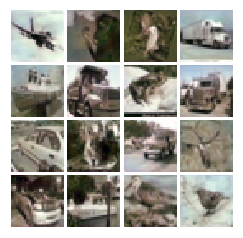

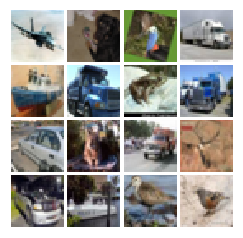

30670848
3072
0.983778951514


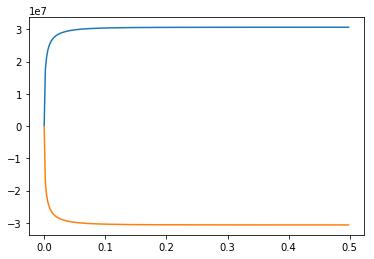

In [12]:
X_test_sampled = X_test[:128*78,:,:,:]

X_test_model_gen = np.zeros([128*78,X_test.shape[1],X_test.shape[2],X_test.shape[3]])
X_orig_model = np.zeros([128*78,X_test.shape[1],X_test.shape[2],X_test.shape[3]])

for i in range(78):
     minibatch = X_test_sampled[i*128:(i+1)*128,:,:,:]
 
    samples,input_samples,gray = sess.run([rgb_out,rgb_in,hsv_in],feed_dict = {Y:minibatch,is_training:True})
    fig = show_images2(gray[:16,:,:,:1])
    plt.show()
    samples[samples>1] = 1
    samples [samples<0] = 0
    fig = show_images(samples[:16])
    plt.show()
    fig = show_images(input_samples[:16])
    plt.show()
    
    X_test_model_gen[i*128:(i+1)*128,:,:,:] = samples[:,:,:,:]
    X_orig_model[i*128:(i+1)*128,:,:,:] = input_samples[:,:,:,:]
 


rgb_i = X_orig_model
rgb_o = X_test_model_gen
rand_indices = np.random.choice(np.arange(128*78),128)
minibatch = rgb_o[rand_indices]
fig = show_images(minibatch[:16])
plt.show()
minibatch = rgb_i[rand_indices]
fig = show_images(minibatch[:16])
plt.show()
print(rgb_i.size)
print(rgb_o[0].size)
auc, ans = AUC(np.reshape(rgb_i, [128*78, 32, 32, 3]), np.reshape(rgb_o, [128*78, 32, 32, 3]))
print(ans)

plt.plot(np.arange(0., 0.5, 0.5/256), auc)
plt.plot(np.arange(0., 0.5, 0.5/256), 1-auc)

In [13]:
def my_model(x,drop_o,is_training):
    
    W_conv = tf.get_variable("Wconv",shape = [7,7,3,32])
    b_conv = tf.get_variable("bconv",shape = [32])
    a1 = tf.nn.conv2d(x, W_conv, strides=[1,1,1,1], padding='SAME') + b_conv
    a1 = tf.contrib.layers.batch_norm(a1,center = True, scale = True, is_training = is_training,scope = 'bn1')
    a1 = tf.nn.relu(a1)
    a1 = tf.nn.max_pool(a1,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'VALID')
    
    W_conv2 = tf.get_variable("Wconv2",shape = [5,5,32,64])
    b_conv2 = tf.get_variable("bconv2",shape = [64])
    a1 = tf.nn.conv2d(a1, W_conv2, strides=[1,1,1,1], padding='SAME') + b_conv2
    a1 = tf.contrib.layers.batch_norm(a1,center = True, scale = True, is_training = is_training,scope = 'bn2')
    a1 = tf.nn.relu(a1)
    
    a1 = tf.nn.max_pool(a1,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'VALID')
    a1 = tf.nn.dropout(a1,drop_o)
   
    W_conv3 = tf.get_variable("Wconv3",shape = [3,3,64,96])
    b_conv3 = tf.get_variable("bconv3",shape = [96])
    a1 = tf.nn.conv2d(a1, W_conv3, strides=[1,1,1,1], padding='SAME') + b_conv3
    a1 = tf.contrib.layers.batch_norm(a1,center = True, scale = True, is_training = is_training,scope = 'bn3')
    a1 = tf.nn.relu(a1)
    a1 = tf.nn.dropout(a1,drop_o)
    #a1 = tf.nn.max_pool(a1,ksize = [1,2,2,1],strides = [1,2,2,1],padding = 'VALID')
    
    a1_flat = tf.reshape(a1,[-1,8*8*96])
    W1 = tf.get_variable("W1",shape = [8*8*96,1024])
    b1 = tf.get_variable("b1",shape = [1024])
    W2 = tf.get_variable("W2",shape = [1024,1024])
    b2 = tf.get_variable("b2",shape = [1024])
    W3 = tf.get_variable("W3",shape = [1024,10])
    b3 = tf.get_variable("b3",shape = [10])
    
    affine = tf.matmul(a1_flat,W1) + b1
    affine = tf.nn.relu(affine)
    affine = tf.nn.dropout(affine,drop_o)
    
    affine = tf.matmul(affine,W2) + b2
    affine = tf.nn.relu(affine)
    affine = tf.nn.dropout(affine,drop_o)
    
    y_out = tf.matmul(affine,W2) + b2
    return y_out
  

In [14]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
dropout = tf.placeholder(tf.float32, shape = ())

with tf.variable_scope("model") as scope:
    y_out = my_model(X,dropout,is_training)

mean_loss = None
optimizer = None

total_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = y_out,labels = y)
mean_loss = tf.reduce_mean(total_loss)

optimizer = tf.train.AdamOptimizer(1e-4)
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [15]:
yuv_converter = np.array([[0.299,0.587,0.114],[-0.14713,-0.2888,0.436],
                                  [0.615,-0.514999,-0.10001]])
inv_mat  = np.array([[1,0,1.13983],[1,-0.39465,-0.58060],[1,2.03211,0]])

sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess,'../models/cifar10_classification/classification_cifar10_model')

batch_size = 64
num_epochs = 78*2
num_correct = 0
num_total = 0
for i in range(num_epochs):
    X_test_samp = X_test_model_gen[i*64:(i+1)*64,:,:,:]
    
    #X_test_YUV = X_test_samp.dot(yuv_converter)
    #X_test_YUV[:,:,:,1:3] = 0
    
    #X_test_samp = X_test_YUV.dot(inv_mat)
    
    Y_test_samp = y_test[i*64:(i+1)*64]
    feed_dict ={X:X_test_samp,y:Y_test_samp,is_training:False,dropout:1}
    prediction = sess.run([y_out],feed_dict)
    
    y_pred = np.argmax(prediction[0],axis = 1)
    #print (y_pred.shape)
    #print()
    num_total += batch_size
    num_correct += sum(np.equal(y_pred, Y_test_samp))
print (num_correct/num_total)

INFO:tensorflow:Restoring parameters from ../models/cifar10_classification/classification_cifar10_model


INFO:tensorflow:Restoring parameters from ../models/cifar10_classification/classification_cifar10_model


0.677584134615
